## Compute lag features for gradient boosting model

In [1]:
import pandas as pd
import numpy as np
import datetime

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
colnames = ['id', 'ts', 'station_name', 'address', 'total_docks',
           'docks_in_service', 'available_docks', 'available_bikes',
           'percent_full', 'status', 'latitude', 'longitude', 'location', 'record']
docks_df = pd.read_csv('/Users/jordi/Downloads/chicago_docks.csv', names=colnames)

In [3]:
# drop unnecessary columns
docks_df = docks_df.drop(columns=['location', 'record'])

In [4]:
docks_df.head()

,id,ts,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,longitude
0,2,10/26/2018 11:55:13 AM,Buckingham Fountain,Buckingham Fountain,39,39,36,3,8,In Service,41.876470,-87.620340
1,3,10/26/2018 11:55:13 AM,Shedd Aquarium,Shedd Aquarium,55,54,50,4,7,In Service,41.867226,-87.615355
2,4,10/26/2018 11:55:13 AM,Burnham Harbor,Burnham Harbor,23,23,9,14,61,In Service,41.856268,-87.613348
3,5,10/26/2018 11:55:13 AM,State St & Harrison St,State St & Harrison St,23,22,20,2,9,In Service,41.874053,-87.627716
4,6,10/26/2018 11:55:13 AM,Dusable Harbor,Dusable Harbor,39,38,32,6,16,In Service,41.886976,-87.612813


In [5]:
docks_df.id.unique().shape

(615,)

In [6]:
stations_df = pd.read_csv('./datasets/chicago_stations.csv')

In [7]:
stations_df.head()

,Unnamed: 0,id,station_name,address,lat,lon
0,0,2,Buckingham Fountain,Buckingham Fountain,41.876470,-87.620340
1,1,3,Shedd Aquarium,Shedd Aquarium,41.867226,-87.615355
2,2,4,Burnham Harbor,Burnham Harbor,41.856268,-87.613348
3,3,5,State St & Harrison St,State St & Harrison St,41.874053,-87.627716
4,4,6,Dusable Harbor,Dusable Harbor,41.886976,-87.612813


In [8]:
stations_df.id.unique().shape

(615,)

In [9]:
station_ids = stations_df.id.unique()

## Preprocess at station level

In [52]:
station_id = 90
df = docks_df[docks_df.id == station_id]
df['ts'] = pd.to_datetime(df.ts, infer_datetime_format=True)

In [53]:
df.ts.min(), df.ts.max()

(Timestamp('2017-01-01 00:05:11'), Timestamp('2018-10-26 11:55:13'))

In [54]:
# round ts every 5 minutes (seconds are not aligned)
df.loc[:, 'ts'] = df.ts.dt.round('5min')
df.sort_values(by='ts', inplace=True)

In [55]:
# resample data, there are missing info gaps
df = df.set_index('ts').resample('10Min', how='last', base=5).bfill()

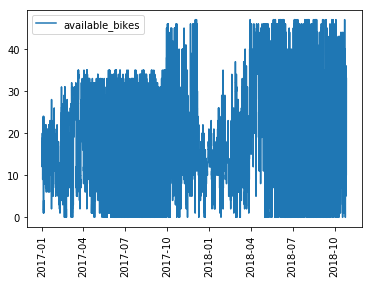

In [56]:
plt.plot(df.index, df.available_bikes, label='available_bikes')
plt.xticks(rotation=90)
plt.legend()

In [57]:
# every hour we have 6 rows, one every 10 minutes
entries_per_hour = 6

In [58]:
# month of year
df['month'] = df.index.month
# quarter of year
df['quarter'] = df.index.quarter
# day of month
df['day'] = df.index.day
# hour of day
df['hour'] = df.index.hour
# cyclic features for hour
df['hour_x'] = np.sin(2*np.pi*df['hour']/24)
df['hour_y'] = np.cos(2*np.pi*df['hour']/24)
# quarter of hour
df['quarter_hour'] = np.floor(df.index.minute / 15)
# day of week
df['dow'] = df.index.dayofweek
# week of year
df['week'] = df.index.weekofyear

In [59]:
ab_daily_mean = df.groupby('day')['available_bikes'].mean()
ab_monthly_mean = df.groupby('month')['available_bikes'].mean()
ab_weekly_mean = df.groupby('week')['available_bikes'].mean()

ab_daily_median = df.groupby('day')['available_bikes'].median()
ab_monthly_median = df.groupby('month')['available_bikes'].median()
ab_weekly_median = df.groupby('week')['available_bikes'].median()

In [60]:
for i, x in zip(ab_daily_mean.index, ab_daily_mean):
    df.loc[df.day == i, 'ab_daily_mean'] = x
    
for i, x in zip(ab_monthly_mean.index, ab_monthly_mean):
    df.loc[df.month == i, 'ab_monthly_mean'] = x
    
for i, x in zip(ab_weekly_mean.index, ab_weekly_mean):
    df.loc[df.week == i, 'ab_weekly_mean'] = x
    
for i, x in zip(ab_daily_median.index, ab_daily_median):
    df.loc[df.day == i, 'ab_daily_median'] = x
    
for i, x in zip(ab_monthly_median.index, ab_monthly_median):
    df.loc[df.month == i, 'ab_monthly_median'] = x
    
for i, x in zip(ab_weekly_median.index, ab_weekly_median):
    df.loc[df.week == i, 'ab_weekly_median'] = x

In [61]:
last_1w_hourly_mean = df.shift(entries_per_hour*24*7 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_1w_daily_mean = df.shift(entries_per_hour*24*7 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()
last_2w_hourly_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_2w_daily_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()

In [62]:
df['last_1w_hourly_mean'] = last_1w_hourly_mean
df['last_1w_daily_mean'] = last_1w_daily_mean
df['last_2w_hourly_mean'] = last_2w_hourly_mean
df['last_2w_daily_mean'] = last_2w_daily_mean

In [63]:
# set status to unknown when status is not available
df.loc[pd.isna(df.status), 'status'] = 'Unknown'

In [64]:
df.columns

Index(['id', 'station_name', 'address', 'total_docks', 'docks_in_service',
       'available_docks', 'available_bikes', 'percent_full', 'status',
       'latitude', 'longitude', 'month', 'quarter', 'day', 'hour', 'hour_x',
       'hour_y', 'quarter_hour', 'dow', 'week', 'ab_daily_mean',
       'ab_monthly_mean', 'ab_weekly_mean', 'ab_daily_median',
       'ab_monthly_median', 'ab_weekly_median', 'last_1w_hourly_mean',
       'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean'],
      dtype='object')

### Set train/test splits

In [65]:
train_df = df.query('20170101 <= ts < 20180928')
# 2 weeks for validation
val_df = df.query('20180928 <= ts < 20181012')
# 2 weeks for test
test_df = df.query('ts >= 20181012')

In [66]:
train_df.shape, val_df.shape, test_df.shape

((91440, 30), (2016, 30), (2088, 30))

In [67]:
# overwrite last_1w_hourly_mean, last_1w_daily_mean columns for the second test week 
# this info is not available at test time!
idx = test_df.shift(freq=datetime.timedelta(weeks=1))[:entries_per_hour*24*7].index
features = ['last_1w_hourly_mean', 'last_1w_daily_mean']
test_df.loc[idx, features] = test_df.loc[idx - datetime.timedelta(weeks=1), features]

In [68]:
# drop first 2 weeks in train, no info for last_1w/2w features
train_df = train_df.iloc[entries_per_hour*24*7*2:]

In [69]:
train_df.shape, val_df.shape, test_df.shape

((89424, 30), (2016, 30), (2088, 30))

In [70]:
train_df.index.min(), train_df.index.max(), val_df.index.min(), val_df.index.max(), test_df.index.min(), test_df.index.max()

(Timestamp('2017-01-15 00:05:00', freq='10T'),
 Timestamp('2018-09-27 23:55:00', freq='10T'),
 Timestamp('2018-09-28 00:05:00', freq='10T'),
 Timestamp('2018-10-11 23:55:00', freq='10T'),
 Timestamp('2018-10-12 00:05:00', freq='10T'),
 Timestamp('2018-10-26 11:55:00', freq='10T'))

In [71]:
xs_features = ['total_docks', 'docks_in_service', 'status', 'ab_daily_mean', 'ab_monthly_mean', 'ab_weekly_mean',
               'ab_daily_median', 'ab_monthly_median', 'ab_weekly_median', 'hour_x', 'hour_y',
              'month', 'quarter', 'day', 'hour', 'quarter_hour', 'dow', 'week', 'last_1w_hourly_mean',
              'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean']
target = ['available_bikes']

le = LabelEncoder()
train_df['status'] = le.fit_transform(train_df['status'])
val_df['status'] = le.transform(val_df['status'])
test_df['status'] = le.transform(test_df['status'])

train_data = lgb.Dataset(train_df[xs_features], label=train_df[target],
                        feature_name=xs_features, categorical_feature=['status'])
val_data = lgb.Dataset(val_df[xs_features], label=val_df[target],
                      feature_name=xs_features, categorical_feature=['status'], reference=train_data)
test_data = lgb.Dataset(test_df[xs_features], label=test_df[target],
                       feature_name=xs_features, categorical_feature=['status'])

In [72]:
test_df.head()

,id,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,...,ab_daily_mean,ab_monthly_mean,ab_weekly_mean,ab_daily_median,ab_monthly_median,ab_weekly_median,last_1w_hourly_mean,last_1w_daily_mean,last_2w_hourly_mean,last_2w_daily_mean
ts,,,,,,,,,,,,,,,,,,,,,
2018-10-12 00:05:00,90.0,Millennium Park,Millennium Park,47.0,46.0,33.0,13.0,28.0,0,41.881032,...,15.346591,17.702679,18.428075,14.0,16.0,17.0,16.0,9.375000,1.000000,12.465278
2018-10-12 00:15:00,90.0,Millennium Park,Millennium Park,47.0,46.0,33.0,13.0,28.0,0,41.881032,...,15.346591,17.702679,18.428075,14.0,16.0,17.0,16.0,9.333333,1.333333,12.534722
2018-10-12 00:25:00,90.0,Millennium Park,Millennium Park,47.0,46.0,33.0,13.0,28.0,0,41.881032,...,15.346591,17.702679,18.428075,14.0,16.0,17.0,16.0,9.291667,1.666667,12.604167
2018-10-12 00:35:00,90.0,Millennium Park,Millennium Park,47.0,46.0,33.0,13.0,28.0,0,41.881032,...,15.346591,17.702679,18.428075,14.0,16.0,17.0,16.0,9.250000,2.000000,12.673611
2018-10-12 00:45:00,90.0,Millennium Park,Millennium Park,47.0,46.0,33.0,13.0,28.0,0,41.881032,...,15.346591,17.702679,18.428075,14.0,16.0,17.0,16.0,9.208333,2.333333,12.743056


In [73]:
params = {
    'objective': 'regression_l2',
    'num_threds': 4,
    'max_depth': 5,
    'num_boost_rounds': 100,
    'bagging_fraction': 0.75,
    'bagging_freq': 3,
    'feature_fraction': 0.75
}
bst = lgb.train(params, train_data, valid_sets=[val_data, test_data], early_stopping_rounds=10)

[1]	valid_0's l2: 147.997	valid_1's l2: 127.806
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 141.509	valid_1's l2: 123.292
[3]	valid_0's l2: 134.246	valid_1's l2: 121.474
[4]	valid_0's l2: 126.831	valid_1's l2: 120.008
[5]	valid_0's l2: 122.91	valid_1's l2: 115.777
[6]	valid_0's l2: 117.271	valid_1's l2: 114.497
[7]	valid_0's l2: 112.764	valid_1's l2: 112.74
[8]	valid_0's l2: 110.507	valid_1's l2: 110.546
[9]	valid_0's l2: 106.606	valid_1's l2: 111.015
[10]	valid_0's l2: 103.624	valid_1's l2: 111.258
[11]	valid_0's l2: 102.511	valid_1's l2: 109.911
[12]	valid_0's l2: 99.1278	valid_1's l2: 106.652
[13]	valid_0's l2: 98.2576	valid_1's l2: 106.79
[14]	valid_0's l2: 96.7932	valid_1's l2: 106.771
[15]	valid_0's l2: 95.0432	valid_1's l2: 106.664
[16]	valid_0's l2: 94.5773	valid_1's l2: 105.914
[17]	valid_0's l2: 94.4287	valid_1's l2: 105.175
[18]	valid_0's l2: 93.7147	valid_1's l2: 105.984
[19]	valid_0's l2: 92.7187	valid_1's l2: 105.708
[20]	valid_0's l2: 

In [74]:
y_true = test_df['available_bikes']
y_hat = bst.predict(test_df[xs_features], num_iteration=bst.best_iteration)

In [75]:
# rmse
np.sqrt(np.mean((y_true - y_hat)**2))

10.23058877958925

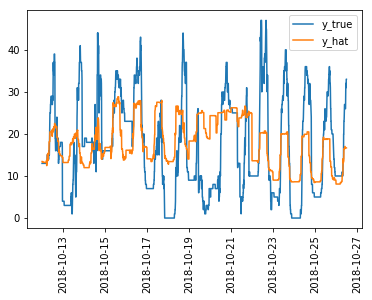

In [76]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()

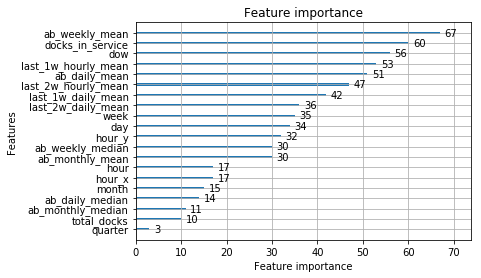

In [77]:
# plot feature importance
lgb.plot_importance(bst)

In [78]:
results = pd.DataFrame({'date': test_df.index, 'y_hat': y_hat, 'y_true': y_true})
results.set_index('date', inplace=True)
results.head()

,y_hat,y_true
date,,
2018-10-12 00:05:00,13.434261,13.0
2018-10-12 00:15:00,13.434261,13.0
2018-10-12 00:25:00,13.434261,13.0
2018-10-12 00:35:00,13.434261,13.0
2018-10-12 00:45:00,13.434261,13.0


# Bayesian optimization with scikit-optimize

In [80]:
ITERATIONS = 50

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        random_state=42
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'bagging_fraction': (0.01, 1.0, 'uniform'),
        'feature_fraction': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (100, 1000)
    },
    cv = StratifiedKFold(
        n_splits=2,
        shuffle=True,
        random_state=42
    ),
    scoring='neg_mean_squared_error',
    n_jobs = 4,
    n_iter = ITERATIONS,   
    verbose = 10,
    refit = True,
    random_state = 42
)

# Fit the model
result = bayes_cv_tuner.fit(pd.concat((train_df, val_df))[xs_features], pd.concat((train_df, val_df))[target])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.4160029192647807, colsample_bytree=0.7304484857455519, feature_fraction=0.9335393188593556, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=766, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863 
[CV] bagging_fraction=0.4160029192647807, colsample_bytree=0.7304484857455519, feature_fraction=0.9335393188593556, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=766, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863 
[CV]  bagging_fraction=0.4160029192647807, colsample_bytree=0.7304484857455519, feature_fraction=0.9335393188593556, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=766, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.3s finished


[CV] bagging_fraction=0.8390144719977516, colsample_bytree=0.8844821246070537, feature_fraction=0.3103760087853332, learning_rate=0.7988179462781242, max_delta_step=17, max_depth=3, min_child_weight=1, n_estimators=418, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782 
[CV] bagging_fraction=0.8390144719977516, colsample_bytree=0.8844821246070537, feature_fraction=0.3103760087853332, learning_rate=0.7988179462781242, max_delta_step=17, max_depth=3, min_child_weight=1, n_estimators=418, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782 
[CV]  bagging_fraction=0.8390144719977516, colsample_bytree=0.8844821246070537, feature_fraction=0.3103760087853332, learning_rate=0.7988179462781242, max_delta_step=17, max_depth=3, min_child_weight=1, n_estimators=418, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782, score=-32.0254770033466, total=   1.1s
[CV]  bagging_fractio

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.5s finished


[CV] bagging_fraction=0.4503841871781403, colsample_bytree=0.9195352964526833, feature_fraction=0.11381056696717655, learning_rate=0.07356404539935663, max_delta_step=4, max_depth=23, min_child_weight=1, n_estimators=776, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411 
[CV] bagging_fraction=0.4503841871781403, colsample_bytree=0.9195352964526833, feature_fraction=0.11381056696717655, learning_rate=0.07356404539935663, max_delta_step=4, max_depth=23, min_child_weight=1, n_estimators=776, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411 
[CV]  bagging_fraction=0.4503841871781403, colsample_bytree=0.9195352964526833, feature_fraction=0.11381056696717655, learning_rate=0.07356404539935663, max_delta_step=4, max_depth=23, min_child_weight=1, n_estimators=776, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411, score=-43.238954261766175, total=   4.7s
[CV]  b

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.0s finished


[CV] bagging_fraction=0.8142720284737898, colsample_bytree=0.1801528457825951, feature_fraction=0.6020666067370067, learning_rate=0.4032083917998946, max_delta_step=10, max_depth=5, min_child_weight=4, n_estimators=885, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015 
[CV] bagging_fraction=0.8142720284737898, colsample_bytree=0.1801528457825951, feature_fraction=0.6020666067370067, learning_rate=0.4032083917998946, max_delta_step=10, max_depth=5, min_child_weight=4, n_estimators=885, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015 
[CV]  bagging_fraction=0.8142720284737898, colsample_bytree=0.1801528457825951, feature_fraction=0.6020666067370067, learning_rate=0.4032083917998946, max_delta_step=10, max_depth=5, min_child_weight=4, n_estimators=885, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015, score=-11.543100984207598, total=   5.5s
[CV]  bagg

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.8s finished


[CV] bagging_fraction=0.8015579071911014, colsample_bytree=0.44364889457651413, feature_fraction=0.5313540347564155, learning_rate=0.2700390206185342, max_delta_step=18, max_depth=36, min_child_weight=2, n_estimators=685, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443 
[CV] bagging_fraction=0.8015579071911014, colsample_bytree=0.44364889457651413, feature_fraction=0.5313540347564155, learning_rate=0.2700390206185342, max_delta_step=18, max_depth=36, min_child_weight=2, n_estimators=685, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443 
[CV]  bagging_fraction=0.8015579071911014, colsample_bytree=0.44364889457651413, feature_fraction=0.5313540347564155, learning_rate=0.2700390206185342, max_delta_step=18, max_depth=36, min_child_weight=2, n_estimators=685, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443, score=-10.270608677711964, total=   3.0s
[CV]

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s finished


[CV] bagging_fraction=0.7366877378057127, colsample_bytree=0.9399760402267441, feature_fraction=0.17197110685216477, learning_rate=0.0238149998729586, max_delta_step=16, max_depth=19, min_child_weight=2, n_estimators=581, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381 
[CV] bagging_fraction=0.7366877378057127, colsample_bytree=0.9399760402267441, feature_fraction=0.17197110685216477, learning_rate=0.0238149998729586, max_delta_step=16, max_depth=19, min_child_weight=2, n_estimators=581, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381 
[CV]  bagging_fraction=0.7366877378057127, colsample_bytree=0.9399760402267441, feature_fraction=0.17197110685216477, learning_rate=0.0238149998729586, max_delta_step=16, max_depth=19, min_child_weight=2, n_estimators=581, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381, score=-42.843933064965675, total=   3.6s
[CV]

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.7s finished


[CV] bagging_fraction=0.6209085649172932, colsample_bytree=0.7776107350396038, feature_fraction=0.3654327026021899, learning_rate=0.5605967693796124, max_delta_step=12, max_depth=30, min_child_weight=3, n_estimators=480, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723 
[CV] bagging_fraction=0.6209085649172932, colsample_bytree=0.7776107350396038, feature_fraction=0.3654327026021899, learning_rate=0.5605967693796124, max_delta_step=12, max_depth=30, min_child_weight=3, n_estimators=480, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723 
[CV]  bagging_fraction=0.6209085649172932, colsample_bytree=0.7776107350396038, feature_fraction=0.3654327026021899, learning_rate=0.5605967693796124, max_delta_step=12, max_depth=30, min_child_weight=3, n_estimators=480, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723, score=-12.343766753493863, total=   2.0s
[CV]  bagg

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.6s finished


[CV] bagging_fraction=0.5479690370134094, colsample_bytree=0.9208091341729433, feature_fraction=0.5015020365607495, learning_rate=0.4734922490673386, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=123, reg_alpha=2.9618722230360503e-06, reg_lambda=8.153638964242, subsample=0.37377280619679043 
[CV] bagging_fraction=0.5479690370134094, colsample_bytree=0.9208091341729433, feature_fraction=0.5015020365607495, learning_rate=0.4734922490673386, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=123, reg_alpha=2.9618722230360503e-06, reg_lambda=8.153638964242, subsample=0.37377280619679043 
[CV]  bagging_fraction=0.5479690370134094, colsample_bytree=0.9208091341729433, feature_fraction=0.5015020365607495, learning_rate=0.4734922490673386, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=123, reg_alpha=2.9618722230360503e-06, reg_lambda=8.153638964242, subsample=0.37377280619679043, score=-43.54435533584712, total=   0.7s
[CV]  bagging_fraction=0.5

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.8s finished


[CV] bagging_fraction=0.955923206446829, colsample_bytree=0.7036152301751524, feature_fraction=0.8729354091785829, learning_rate=0.06786442521779147, max_delta_step=8, max_depth=11, min_child_weight=0, n_estimators=434, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489 
[CV] bagging_fraction=0.955923206446829, colsample_bytree=0.7036152301751524, feature_fraction=0.8729354091785829, learning_rate=0.06786442521779147, max_delta_step=8, max_depth=11, min_child_weight=0, n_estimators=434, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489 
[CV]  bagging_fraction=0.955923206446829, colsample_bytree=0.7036152301751524, feature_fraction=0.8729354091785829, learning_rate=0.06786442521779147, max_delta_step=8, max_depth=11, min_child_weight=0, n_estimators=434, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489, score=-21.110611324236068, total=   2.9s
[

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.013594004182195795, colsample_bytree=0.819651719467114, feature_fraction=0.743869916924347, learning_rate=0.03229300915669146, max_delta_step=12, max_depth=14, min_child_weight=2, n_estimators=237, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526 
[CV] bagging_fraction=0.013594004182195795, colsample_bytree=0.819651719467114, feature_fraction=0.743869916924347, learning_rate=0.03229300915669146, max_delta_step=12, max_depth=14, min_child_weight=2, n_estimators=237, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526 
[CV]  bagging_fraction=0.013594004182195795, colsample_bytree=0.819651719467114, feature_fraction=0.743869916924347, learning_rate=0.03229300915669146, max_delta_step=12, max_depth=14, min_child_weight=2, n_estimators=237, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526, s

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.01, colsample_bytree=0.1788904012673087, feature_fraction=0.01, learning_rate=0.034690307365005474, max_delta_step=0, max_depth=50, min_child_weight=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.038475750251823995, subsample=1.0 
[CV] bagging_fraction=0.01, colsample_bytree=0.1788904012673087, feature_fraction=0.01, learning_rate=0.034690307365005474, max_delta_step=0, max_depth=50, min_child_weight=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.038475750251823995, subsample=1.0 
[CV]  bagging_fraction=0.01, colsample_bytree=0.1788904012673087, feature_fraction=0.01, learning_rate=0.034690307365005474, max_delta_step=0, max_depth=50, min_child_weight=5, n_estimators=100, reg_alpha=1.0, reg_lambda=0.038475750251823995, subsample=1.0, score=-88.75523244846104, total=   0.5s
[CV]  bagging_fraction=0.01, colsample_bytree=0.1788904012673087, feature_fraction=0.01, learning_rate=0.034690307365005474, max_

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.7067769221213658, colsample_bytree=0.5938522974005767, feature_fraction=0.42057168878604045, learning_rate=0.4568435134123797, max_delta_step=16, max_depth=2, min_child_weight=2, n_estimators=695, reg_alpha=0.0006977065905326317, reg_lambda=0.06604417917302549, subsample=0.6146257721974441 
[CV] bagging_fraction=0.7067769221213658, colsample_bytree=0.5938522974005767, feature_fraction=0.42057168878604045, learning_rate=0.4568435134123797, max_delta_step=16, max_depth=2, min_child_weight=2, n_estimators=695, reg_alpha=0.0006977065905326317, reg_lambda=0.06604417917302549, subsample=0.6146257721974441 
[CV]  bagging_fraction=0.7067769221213658, colsample_bytree=0.5938522974005767, feature_fraction=0.42057168878604045, learning_rate=0.4568435134123797, max_delta_step=16, max_depth=2, min_child_weight=2, n_estimators=695, reg_alpha=0.0006977065905326317, reg_lambda=0.06604417917302549, subsample=0.6146257721

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.5615601884278149, colsample_bytree=0.4525366256459031, feature_fraction=0.47528305164006607, learning_rate=0.1359903419261845, max_delta_step=18, max_depth=35, min_child_weight=2, n_estimators=691, reg_alpha=6.886300675857153e-08, reg_lambda=0.0560238825113653, subsample=0.48407876859178084 
[CV] bagging_fraction=0.5615601884278149, colsample_bytree=0.4525366256459031, feature_fraction=0.47528305164006607, learning_rate=0.1359903419261845, max_delta_step=18, max_depth=35, min_child_weight=2, n_estimators=691, reg_alpha=6.886300675857153e-08, reg_lambda=0.0560238825113653, subsample=0.48407876859178084 
[CV]  bagging_fraction=0.5615601884278149, colsample_bytree=0.4525366256459031, feature_fraction=0.47528305164006607, learning_rate=0.1359903419261845, max_delta_step=18, max_depth=35, min_child_weight=2, n_estimators=691, reg_alpha=6.886300675857153e-08, reg_lambda=0.0560238825113653, subsample=0.48407876

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.2s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.013670819313426497, colsample_bytree=0.6491402178219293, feature_fraction=0.6134343594862075, learning_rate=0.5449405652393333, max_delta_step=17, max_depth=37, min_child_weight=2, n_estimators=682, reg_alpha=1.6502964777047756e-06, reg_lambda=0.33427396965007994, subsample=0.3798986864513759 
[CV] bagging_fraction=0.013670819313426497, colsample_bytree=0.6491402178219293, feature_fraction=0.6134343594862075, learning_rate=0.5449405652393333, max_delta_step=17, max_depth=37, min_child_weight=2, n_estimators=682, reg_alpha=1.6502964777047756e-06, reg_lambda=0.33427396965007994, subsample=0.3798986864513759 
[CV]  bagging_fraction=0.013670819313426497, colsample_bytree=0.6491402178219293, feature_fraction=0.6134343594862075, learning_rate=0.5449405652393333, max_delta_step=17, max_depth=37, min_child_weight=2, n_estimators=682, reg_alpha=1.6502964777047756e-06, reg_lambda=0.33427396965007994, subsample=0.3

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=12, max_depth=50, min_child_weight=1, n_estimators=1000, reg_alpha=1e-09, reg_lambda=0.07841213466735547, subsample=0.7621677436118618 
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=12, max_depth=50, min_child_weight=1, n_estimators=1000, reg_alpha=1e-09, reg_lambda=0.07841213466735547, subsample=0.7621677436118618 
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=12, max_depth=50, min_child_weight=1, n_estimators=1000, reg_alpha=1e-09, reg_lambda=0.07841213466735547, subsample=0.7621677436118618, score=-14.945287534983855, total=   6.8s
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=12, max_depth=50, min_child_weight=1, n_estimators=1000, reg_alpha

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.9757341837766084, colsample_bytree=0.46530045368192485, feature_fraction=0.669167604715534, learning_rate=0.12400895543138091, max_delta_step=7, max_depth=38, min_child_weight=2, n_estimators=662, reg_alpha=4.829242063708429e-07, reg_lambda=0.0031055270175738385, subsample=0.49153252517471135 
[CV] bagging_fraction=0.9757341837766084, colsample_bytree=0.46530045368192485, feature_fraction=0.669167604715534, learning_rate=0.12400895543138091, max_delta_step=7, max_depth=38, min_child_weight=2, n_estimators=662, reg_alpha=4.829242063708429e-07, reg_lambda=0.0031055270175738385, subsample=0.49153252517471135 
[CV]  bagging_fraction=0.9757341837766084, colsample_bytree=0.46530045368192485, feature_fraction=0.669167604715534, learning_rate=0.12400895543138091, max_delta_step=7, max_depth=38, min_child_weight=2, n_estimators=662, reg_alpha=4.829242063708429e-07, reg_lambda=0.0031055270175738385, subsample=0.49

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=3, n_estimators=894, reg_alpha=1.0, reg_lambda=1.3206357053332811e-06, subsample=1.0 
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=3, n_estimators=894, reg_alpha=1.0, reg_lambda=1.3206357053332811e-06, subsample=1.0 
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=3, n_estimators=894, reg_alpha=1.0, reg_lambda=1.3206357053332811e-06, subsample=1.0, score=-15.600906806934487, total=   5.7s
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=3, n_estimators=894, reg_alpha=1.0, reg_lambda=1.3206357053332811e-06, subsa

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.4s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=0.6276794992367489, learning_rate=1.0, max_delta_step=20, max_depth=30, min_child_weight=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=15.783447160629107, subsample=0.4339232962134005 
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=0.6276794992367489, learning_rate=1.0, max_delta_step=20, max_depth=30, min_child_weight=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=15.783447160629107, subsample=0.4339232962134005 
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=0.6276794992367489, learning_rate=1.0, max_delta_step=20, max_depth=30, min_child_weight=3, n_estimators=1000, reg_alpha=1.0, reg_lambda=15.783447160629107, subsample=0.4339232962134005, score=-12.425006799450301, total=   5.1s
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=0.6276794992367489, learning_rate=1.0, max_delta_step=20, max_depth=3

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.627682739883648, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=36, min_child_weight=2, n_estimators=982, reg_alpha=0.7327281330229588, reg_lambda=0.0008672906327364588, subsample=1.0 
[CV] bagging_fraction=1.0, colsample_bytree=0.627682739883648, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=36, min_child_weight=2, n_estimators=982, reg_alpha=0.7327281330229588, reg_lambda=0.0008672906327364588, subsample=1.0 
[CV]  bagging_fraction=1.0, colsample_bytree=0.627682739883648, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=36, min_child_weight=2, n_estimators=982, reg_alpha=0.7327281330229588, reg_lambda=0.0008672906327364588, subsample=1.0, score=-15.072338841393286, total=   6.0s
[CV]  bagging_fraction=1.0, colsample_bytree=0.627682739883648, feature_fraction=1.0, learning_rate=1.0, max_delta_step=20, max_depth=36,

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=18, max_depth=0, min_child_weight=5, n_estimators=1000, reg_alpha=0.27035800790756614, reg_lambda=1e-09, subsample=0.40718480538426777 
[CV] bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=18, max_depth=0, min_child_weight=5, n_estimators=1000, reg_alpha=0.27035800790756614, reg_lambda=1e-09, subsample=0.40718480538426777 
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=18, max_depth=0, min_child_weight=5, n_estimators=1000, reg_alpha=0.27035800790756614, reg_lambda=1e-09, subsample=0.40718480538426777, score=-15.411037735763939, total=   6.5s
[CV]  bagging_fraction=1.0, colsample_bytree=0.01, feature_fraction=1.0, learning_rate=1.0, max_delta_step=18, max_depth=0, min_child_weight=5, n_estimators=1000, reg_alpha=

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.7515871245269327, colsample_bytree=0.5025706585773114, feature_fraction=0.5428954424419918, learning_rate=0.3623732394655187, max_delta_step=18, max_depth=36, min_child_weight=2, n_estimators=684, reg_alpha=1.3395203308700802e-06, reg_lambda=0.04237872946886635, subsample=0.48731561581790017 
[CV] bagging_fraction=0.7515871245269327, colsample_bytree=0.5025706585773114, feature_fraction=0.5428954424419918, learning_rate=0.3623732394655187, max_delta_step=18, max_depth=36, min_child_weight=2, n_estimators=684, reg_alpha=1.3395203308700802e-06, reg_lambda=0.04237872946886635, subsample=0.48731561581790017 
[CV]  bagging_fraction=0.7515871245269327, colsample_bytree=0.5025706585773114, feature_fraction=0.5428954424419918, learning_rate=0.3623732394655187, max_delta_step=18, max_depth=36, min_child_weight=2, n_estimators=684, reg_alpha=1.3395203308700802e-06, reg_lambda=0.04237872946886635, subsample=0.48731

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.8706954408894295, colsample_bytree=1.0, feature_fraction=0.4847418212587622, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=5, n_estimators=523, reg_alpha=2.631179968820358e-07, reg_lambda=7.864528129378356e-09, subsample=0.34247337682452894 
[CV] bagging_fraction=0.8706954408894295, colsample_bytree=1.0, feature_fraction=0.4847418212587622, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=5, n_estimators=523, reg_alpha=2.631179968820358e-07, reg_lambda=7.864528129378356e-09, subsample=0.34247337682452894 
[CV]  bagging_fraction=0.8706954408894295, colsample_bytree=1.0, feature_fraction=0.4847418212587622, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=5, n_estimators=523, reg_alpha=2.631179968820358e-07, reg_lambda=7.864528129378356e-09, subsample=0.34247337682452894, score=-16.58322337700162, total=   2.4s
[CV]  bagging_fraction=0.87069544

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.57806753608262, colsample_bytree=0.3946112995831112, feature_fraction=0.5564180707122061, learning_rate=0.3265500365827108, max_delta_step=16, max_depth=37, min_child_weight=2, n_estimators=684, reg_alpha=1.416406873501505e-05, reg_lambda=3.040379546141089, subsample=0.5079108688911033 
[CV] bagging_fraction=0.57806753608262, colsample_bytree=0.3946112995831112, feature_fraction=0.5564180707122061, learning_rate=0.3265500365827108, max_delta_step=16, max_depth=37, min_child_weight=2, n_estimators=684, reg_alpha=1.416406873501505e-05, reg_lambda=3.040379546141089, subsample=0.5079108688911033 
[CV]  bagging_fraction=0.57806753608262, colsample_bytree=0.3946112995831112, feature_fraction=0.5564180707122061, learning_rate=0.3265500365827108, max_delta_step=16, max_depth=37, min_child_weight=2, n_estimators=684, reg_alpha=1.416406873501505e-05, reg_lambda=3.040379546141089, subsample=0.5079108688911033, scor

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.7712594102061191, colsample_bytree=0.9817822771143622, feature_fraction=0.553114888789379, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=2, n_estimators=682, reg_alpha=1.3559008610068425e-09, reg_lambda=1.0173421638312725e-09, subsample=0.3100524067850317 
[CV] bagging_fraction=0.7712594102061191, colsample_bytree=0.9817822771143622, feature_fraction=0.553114888789379, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=2, n_estimators=682, reg_alpha=1.3559008610068425e-09, reg_lambda=1.0173421638312725e-09, subsample=0.3100524067850317 
[CV]  bagging_fraction=0.7712594102061191, colsample_bytree=0.9817822771143622, feature_fraction=0.553114888789379, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=2, n_estimators=682, reg_alpha=1.3559008610068425e-09, reg_lambda=1.0173421638312725e-09, subsample=0.3100524067850317, score=-16.227683489477258, t

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.6108241110731782, colsample_bytree=0.01, feature_fraction=0.648924274457173, learning_rate=0.05379149625696373, max_delta_step=12, max_depth=12, min_child_weight=3, n_estimators=918, reg_alpha=0.0010828077688550567, reg_lambda=2.2443097739596556e-05, subsample=0.6907662792149267 
[CV] bagging_fraction=0.6108241110731782, colsample_bytree=0.01, feature_fraction=0.648924274457173, learning_rate=0.05379149625696373, max_delta_step=12, max_depth=12, min_child_weight=3, n_estimators=918, reg_alpha=0.0010828077688550567, reg_lambda=2.2443097739596556e-05, subsample=0.6907662792149267 
[CV]  bagging_fraction=0.6108241110731782, colsample_bytree=0.01, feature_fraction=0.648924274457173, learning_rate=0.05379149625696373, max_delta_step=12, max_depth=12, min_child_weight=3, n_estimators=918, reg_alpha=0.0010828077688550567, reg_lambda=2.2443097739596556e-05, subsample=0.6907662792149267, score=-16.763240352925628

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.6736124570060825, colsample_bytree=0.06673292202656232, feature_fraction=0.5593201315919005, learning_rate=0.3328582241913494, max_delta_step=19, max_depth=37, min_child_weight=1, n_estimators=682, reg_alpha=2.22555212542661e-05, reg_lambda=0.05885125539922897, subsample=0.5254455113055715 
[CV] bagging_fraction=0.6736124570060825, colsample_bytree=0.06673292202656232, feature_fraction=0.5593201315919005, learning_rate=0.3328582241913494, max_delta_step=19, max_depth=37, min_child_weight=1, n_estimators=682, reg_alpha=2.22555212542661e-05, reg_lambda=0.05885125539922897, subsample=0.5254455113055715 
[CV]  bagging_fraction=0.6736124570060825, colsample_bytree=0.06673292202656232, feature_fraction=0.5593201315919005, learning_rate=0.3328582241913494, max_delta_step=19, max_depth=37, min_child_weight=1, n_estimators=682, reg_alpha=2.22555212542661e-05, reg_lambda=0.05885125539922897, subsample=0.5254455113

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.28260058632001295, colsample_bytree=0.6145765449373329, feature_fraction=0.5646673362126229, learning_rate=0.9743984510099306, max_delta_step=20, max_depth=36, min_child_weight=2, n_estimators=677, reg_alpha=2.451432427921235e-06, reg_lambda=1.8199716001205322e-09, subsample=0.8732746280486874 
[CV] bagging_fraction=0.28260058632001295, colsample_bytree=0.6145765449373329, feature_fraction=0.5646673362126229, learning_rate=0.9743984510099306, max_delta_step=20, max_depth=36, min_child_weight=2, n_estimators=677, reg_alpha=2.451432427921235e-06, reg_lambda=1.8199716001205322e-09, subsample=0.8732746280486874 
[CV]  bagging_fraction=0.28260058632001295, colsample_bytree=0.6145765449373329, feature_fraction=0.5646673362126229, learning_rate=0.9743984510099306, max_delta_step=20, max_depth=36, min_child_weight=2, n_estimators=677, reg_alpha=2.451432427921235e-06, reg_lambda=1.8199716001205322e-09, subsample=

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=1.0, feature_fraction=0.4603227873319063, learning_rate=0.6669559605156336, max_delta_step=16, max_depth=35, min_child_weight=5, n_estimators=490, reg_alpha=0.0011234263323334152, reg_lambda=0.21473337923513636, subsample=0.9891897372947357 
[CV] bagging_fraction=1.0, colsample_bytree=1.0, feature_fraction=0.4603227873319063, learning_rate=0.6669559605156336, max_delta_step=16, max_depth=35, min_child_weight=5, n_estimators=490, reg_alpha=0.0011234263323334152, reg_lambda=0.21473337923513636, subsample=0.9891897372947357 
[CV]  bagging_fraction=1.0, colsample_bytree=1.0, feature_fraction=0.4603227873319063, learning_rate=0.6669559605156336, max_delta_step=16, max_depth=35, min_child_weight=5, n_estimators=490, reg_alpha=0.0011234263323334152, reg_lambda=0.21473337923513636, subsample=0.9891897372947357, score=-12.395842910752268, total=   2.3s
[CV]  bagging_fraction=1.0, colsample_byt

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.9258333353718824, colsample_bytree=0.7381457297770417, feature_fraction=0.561858329986831, learning_rate=0.2694629661474131, max_delta_step=13, max_depth=36, min_child_weight=1, n_estimators=685, reg_alpha=1.215015691539402e-05, reg_lambda=0.10350128425283933, subsample=0.46588138780476757 
[CV] bagging_fraction=0.9258333353718824, colsample_bytree=0.7381457297770417, feature_fraction=0.561858329986831, learning_rate=0.2694629661474131, max_delta_step=13, max_depth=36, min_child_weight=1, n_estimators=685, reg_alpha=1.215015691539402e-05, reg_lambda=0.10350128425283933, subsample=0.46588138780476757 
[CV]  bagging_fraction=0.9258333353718824, colsample_bytree=0.7381457297770417, feature_fraction=0.561858329986831, learning_rate=0.2694629661474131, max_delta_step=13, max_depth=36, min_child_weight=1, n_estimators=685, reg_alpha=1.215015691539402e-05, reg_lambda=0.10350128425283933, subsample=0.46588138780

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.2818649342239163, colsample_bytree=0.9666601086062534, feature_fraction=0.587238046903989, learning_rate=0.0637616757463479, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=886, reg_alpha=2.4754867824456792e-08, reg_lambda=0.0015357015550485698, subsample=0.20389193448483148 
[CV] bagging_fraction=0.2818649342239163, colsample_bytree=0.9666601086062534, feature_fraction=0.587238046903989, learning_rate=0.0637616757463479, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=886, reg_alpha=2.4754867824456792e-08, reg_lambda=0.0015357015550485698, subsample=0.20389193448483148 
[CV]  bagging_fraction=0.2818649342239163, colsample_bytree=0.9666601086062534, feature_fraction=0.587238046903989, learning_rate=0.0637616757463479, max_delta_step=12, max_depth=0, min_child_weight=5, n_estimators=886, reg_alpha=2.4754867824456792e-08, reg_lambda=0.0015357015550485698, subsample=0.20389

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.7860432140579856, feature_fraction=0.6152797002621475, learning_rate=1.0, max_delta_step=14, max_depth=6, min_child_weight=5, n_estimators=894, reg_alpha=0.0009451393784159883, reg_lambda=6.498711538013117e-05, subsample=0.30934794410856636 
[CV] bagging_fraction=1.0, colsample_bytree=0.7860432140579856, feature_fraction=0.6152797002621475, learning_rate=1.0, max_delta_step=14, max_depth=6, min_child_weight=5, n_estimators=894, reg_alpha=0.0009451393784159883, reg_lambda=6.498711538013117e-05, subsample=0.30934794410856636 
[CV]  bagging_fraction=1.0, colsample_bytree=0.7860432140579856, feature_fraction=0.6152797002621475, learning_rate=1.0, max_delta_step=14, max_depth=6, min_child_weight=5, n_estimators=894, reg_alpha=0.0009451393784159883, reg_lambda=6.498711538013117e-05, subsample=0.30934794410856636, score=-15.092302057461637, total=   4.5s
[CV]  bagging_fraction=1.0, colsamp

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.6s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.48538125392269943, colsample_bytree=0.15462318747615372, feature_fraction=0.5875070893252489, learning_rate=0.014399711473591243, max_delta_step=4, max_depth=4, min_child_weight=4, n_estimators=877, reg_alpha=1.0, reg_lambda=4.5038498029326056e-05, subsample=0.6904607050864845 
[CV] bagging_fraction=0.48538125392269943, colsample_bytree=0.15462318747615372, feature_fraction=0.5875070893252489, learning_rate=0.014399711473591243, max_delta_step=4, max_depth=4, min_child_weight=4, n_estimators=877, reg_alpha=1.0, reg_lambda=4.5038498029326056e-05, subsample=0.6904607050864845 
[CV]  bagging_fraction=0.48538125392269943, colsample_bytree=0.15462318747615372, feature_fraction=0.5875070893252489, learning_rate=0.014399711473591243, max_delta_step=4, max_depth=4, min_child_weight=4, n_estimators=877, reg_alpha=1.0, reg_lambda=4.5038498029326056e-05, subsample=0.6904607050864845, score=-51.934582980958254, tota

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.5723836218019955, colsample_bytree=0.3528296456779454, feature_fraction=0.6782343029090637, learning_rate=0.2937622803122903, max_delta_step=14, max_depth=9, min_child_weight=4, n_estimators=1000, reg_alpha=0.021037957260594337, reg_lambda=0.029579962719700672, subsample=0.28779991831641477 
[CV] bagging_fraction=0.5723836218019955, colsample_bytree=0.3528296456779454, feature_fraction=0.6782343029090637, learning_rate=0.2937622803122903, max_delta_step=14, max_depth=9, min_child_weight=4, n_estimators=1000, reg_alpha=0.021037957260594337, reg_lambda=0.029579962719700672, subsample=0.28779991831641477 
[CV]  bagging_fraction=0.5723836218019955, colsample_bytree=0.3528296456779454, feature_fraction=0.6782343029090637, learning_rate=0.2937622803122903, max_delta_step=14, max_depth=9, min_child_weight=4, n_estimators=1000, reg_alpha=0.021037957260594337, reg_lambda=0.029579962719700672, subsample=0.28779991

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.8764389667090459, colsample_bytree=0.2614840174965455, feature_fraction=0.5858071673146048, learning_rate=0.8111458195041246, max_delta_step=18, max_depth=39, min_child_weight=2, n_estimators=666, reg_alpha=0.5008370673740354, reg_lambda=165.1112198087483, subsample=0.3394177615235148 
[CV] bagging_fraction=0.8764389667090459, colsample_bytree=0.2614840174965455, feature_fraction=0.5858071673146048, learning_rate=0.8111458195041246, max_delta_step=18, max_depth=39, min_child_weight=2, n_estimators=666, reg_alpha=0.5008370673740354, reg_lambda=165.1112198087483, subsample=0.3394177615235148 
[CV]  bagging_fraction=0.8764389667090459, colsample_bytree=0.2614840174965455, feature_fraction=0.5858071673146048, learning_rate=0.8111458195041246, max_delta_step=18, max_depth=39, min_child_weight=2, n_estimators=666, reg_alpha=0.5008370673740354, reg_lambda=165.1112198087483, subsample=0.3394177615235148, score=-

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.2s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.09871477135161656, feature_fraction=0.574743500526179, learning_rate=0.41546926338712087, max_delta_step=18, max_depth=40, min_child_weight=2, n_estimators=679, reg_alpha=0.023326152886388472, reg_lambda=5.291702902321275, subsample=0.4792135182400725 
[CV] bagging_fraction=1.0, colsample_bytree=0.09871477135161656, feature_fraction=0.574743500526179, learning_rate=0.41546926338712087, max_delta_step=18, max_depth=40, min_child_weight=2, n_estimators=679, reg_alpha=0.023326152886388472, reg_lambda=5.291702902321275, subsample=0.4792135182400725 
[CV]  bagging_fraction=1.0, colsample_bytree=0.09871477135161656, feature_fraction=0.574743500526179, learning_rate=0.41546926338712087, max_delta_step=18, max_depth=40, min_child_weight=2, n_estimators=679, reg_alpha=0.023326152886388472, reg_lambda=5.291702902321275, subsample=0.4792135182400725, score=-9.963315860136674, total=   3.3s
[CV

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.6s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.8484507747967368, feature_fraction=0.6978573886212172, learning_rate=0.18645882411422265, max_delta_step=14, max_depth=5, min_child_weight=4, n_estimators=937, reg_alpha=8.952681146573187e-09, reg_lambda=0.00010969520823611112, subsample=0.158626916272124 
[CV] bagging_fraction=1.0, colsample_bytree=0.8484507747967368, feature_fraction=0.6978573886212172, learning_rate=0.18645882411422265, max_delta_step=14, max_depth=5, min_child_weight=4, n_estimators=937, reg_alpha=8.952681146573187e-09, reg_lambda=0.00010969520823611112, subsample=0.158626916272124 
[CV]  bagging_fraction=1.0, colsample_bytree=0.8484507747967368, feature_fraction=0.6978573886212172, learning_rate=0.18645882411422265, max_delta_step=14, max_depth=5, min_child_weight=4, n_estimators=937, reg_alpha=8.952681146573187e-09, reg_lambda=0.00010969520823611112, subsample=0.158626916272124, score=-12.899340848988547, tota

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.8219864818768959, colsample_bytree=0.12933925105875518, feature_fraction=0.690106390713439, learning_rate=0.4116974746075905, max_delta_step=13, max_depth=8, min_child_weight=2, n_estimators=1000, reg_alpha=0.00011145097932922893, reg_lambda=0.20963427937557227, subsample=0.6835083364973487 
[CV] bagging_fraction=0.8219864818768959, colsample_bytree=0.12933925105875518, feature_fraction=0.690106390713439, learning_rate=0.4116974746075905, max_delta_step=13, max_depth=8, min_child_weight=2, n_estimators=1000, reg_alpha=0.00011145097932922893, reg_lambda=0.20963427937557227, subsample=0.6835083364973487 
[CV]  bagging_fraction=0.8219864818768959, colsample_bytree=0.12933925105875518, feature_fraction=0.690106390713439, learning_rate=0.4116974746075905, max_delta_step=13, max_depth=8, min_child_weight=2, n_estimators=1000, reg_alpha=0.00011145097932922893, reg_lambda=0.20963427937557227, subsample=0.6835083

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.9498842992646002, colsample_bytree=0.731398789499771, feature_fraction=0.8194970108513593, learning_rate=0.33350643687321974, max_delta_step=10, max_depth=36, min_child_weight=3, n_estimators=646, reg_alpha=0.022151032668799378, reg_lambda=0.13767668689040655, subsample=0.43314121326708177 
[CV] bagging_fraction=0.9498842992646002, colsample_bytree=0.731398789499771, feature_fraction=0.8194970108513593, learning_rate=0.33350643687321974, max_delta_step=10, max_depth=36, min_child_weight=3, n_estimators=646, reg_alpha=0.022151032668799378, reg_lambda=0.13767668689040655, subsample=0.43314121326708177 
[CV]  bagging_fraction=0.9498842992646002, colsample_bytree=0.731398789499771, feature_fraction=0.8194970108513593, learning_rate=0.33350643687321974, max_delta_step=10, max_depth=36, min_child_weight=3, n_estimators=646, reg_alpha=0.022151032668799378, reg_lambda=0.13767668689040655, subsample=0.43314121326

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.0767651137701589, feature_fraction=0.5834703410160245, learning_rate=0.3870927678906507, max_delta_step=15, max_depth=13, min_child_weight=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1000.0, subsample=0.01 
[CV] bagging_fraction=1.0, colsample_bytree=0.0767651137701589, feature_fraction=0.5834703410160245, learning_rate=0.3870927678906507, max_delta_step=15, max_depth=13, min_child_weight=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1000.0, subsample=0.01 
[CV]  bagging_fraction=1.0, colsample_bytree=0.0767651137701589, feature_fraction=0.5834703410160245, learning_rate=0.3870927678906507, max_delta_step=15, max_depth=13, min_child_weight=5, n_estimators=1000, reg_alpha=1.0, reg_lambda=1000.0, subsample=0.01, score=-12.085023797095484, total=   6.5s
[CV]  bagging_fraction=1.0, colsample_bytree=0.0767651137701589, feature_fraction=0.5834703410160245, learning_rate=0.3870927678

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.42673065193931364, colsample_bytree=0.975369261792799, feature_fraction=0.724310997973617, learning_rate=0.28052447577032197, max_delta_step=14, max_depth=7, min_child_weight=5, n_estimators=1000, reg_alpha=1.996940233331393e-05, reg_lambda=5.864322554364854e-05, subsample=0.6014244321321758 
[CV] bagging_fraction=0.42673065193931364, colsample_bytree=0.975369261792799, feature_fraction=0.724310997973617, learning_rate=0.28052447577032197, max_delta_step=14, max_depth=7, min_child_weight=5, n_estimators=1000, reg_alpha=1.996940233331393e-05, reg_lambda=5.864322554364854e-05, subsample=0.6014244321321758 
[CV]  bagging_fraction=0.42673065193931364, colsample_bytree=0.975369261792799, feature_fraction=0.724310997973617, learning_rate=0.28052447577032197, max_delta_step=14, max_depth=7, min_child_weight=5, n_estimators=1000, reg_alpha=1.996940233331393e-05, reg_lambda=5.864322554364854e-05, subsample=0.6014

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.12239885819648667, colsample_bytree=0.41574077325293946, feature_fraction=0.7043040849436828, learning_rate=0.37558629684031236, max_delta_step=12, max_depth=8, min_child_weight=3, n_estimators=1000, reg_alpha=0.05936400987062541, reg_lambda=0.0008075387023909189, subsample=0.4220356298526114 
[CV] bagging_fraction=0.12239885819648667, colsample_bytree=0.41574077325293946, feature_fraction=0.7043040849436828, learning_rate=0.37558629684031236, max_delta_step=12, max_depth=8, min_child_weight=3, n_estimators=1000, reg_alpha=0.05936400987062541, reg_lambda=0.0008075387023909189, subsample=0.4220356298526114 
[CV]  bagging_fraction=0.12239885819648667, colsample_bytree=0.41574077325293946, feature_fraction=0.7043040849436828, learning_rate=0.37558629684031236, max_delta_step=12, max_depth=8, min_child_weight=3, n_estimators=1000, reg_alpha=0.05936400987062541, reg_lambda=0.0008075387023909189, subsample=0.4

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=1.0, colsample_bytree=0.9138386431702025, feature_fraction=0.6633659329827044, learning_rate=0.3910844247916495, max_delta_step=10, max_depth=36, min_child_weight=2, n_estimators=646, reg_alpha=3.3490574064805062e-06, reg_lambda=1.4531543396346475e-05, subsample=0.01 
[CV] bagging_fraction=1.0, colsample_bytree=0.9138386431702025, feature_fraction=0.6633659329827044, learning_rate=0.3910844247916495, max_delta_step=10, max_depth=36, min_child_weight=2, n_estimators=646, reg_alpha=3.3490574064805062e-06, reg_lambda=1.4531543396346475e-05, subsample=0.01 
[CV]  bagging_fraction=1.0, colsample_bytree=0.9138386431702025, feature_fraction=0.6633659329827044, learning_rate=0.3910844247916495, max_delta_step=10, max_depth=36, min_child_weight=2, n_estimators=646, reg_alpha=3.3490574064805062e-06, reg_lambda=1.4531543396346475e-05, subsample=0.01, score=-9.881790940238442, total=   3.0s
[CV]  bagging_fraction=1.0,

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.15560891233763907, colsample_bytree=0.5890525557659319, feature_fraction=0.6914182441027263, learning_rate=0.31933588792832257, max_delta_step=13, max_depth=6, min_child_weight=4, n_estimators=1000, reg_alpha=0.002846894789234621, reg_lambda=3.2034179992582286e-05, subsample=0.05340670225854634 
[CV] bagging_fraction=0.15560891233763907, colsample_bytree=0.5890525557659319, feature_fraction=0.6914182441027263, learning_rate=0.31933588792832257, max_delta_step=13, max_depth=6, min_child_weight=4, n_estimators=1000, reg_alpha=0.002846894789234621, reg_lambda=3.2034179992582286e-05, subsample=0.05340670225854634 
[CV]  bagging_fraction=0.15560891233763907, colsample_bytree=0.5890525557659319, feature_fraction=0.6914182441027263, learning_rate=0.31933588792832257, max_delta_step=13, max_depth=6, min_child_weight=4, n_estimators=1000, reg_alpha=0.002846894789234621, reg_lambda=3.2034179992582286e-05, subsampl

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.6s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.7053650439683634, colsample_bytree=0.5251816860429372, feature_fraction=0.7154390273189716, learning_rate=0.2876968820316744, max_delta_step=15, max_depth=11, min_child_weight=3, n_estimators=998, reg_alpha=0.005753278420922745, reg_lambda=1.137854718088444e-05, subsample=0.9539940392416151 
[CV] bagging_fraction=0.7053650439683634, colsample_bytree=0.5251816860429372, feature_fraction=0.7154390273189716, learning_rate=0.2876968820316744, max_delta_step=15, max_depth=11, min_child_weight=3, n_estimators=998, reg_alpha=0.005753278420922745, reg_lambda=1.137854718088444e-05, subsample=0.9539940392416151 
[CV]  bagging_fraction=0.7053650439683634, colsample_bytree=0.5251816860429372, feature_fraction=0.7154390273189716, learning_rate=0.2876968820316744, max_delta_step=15, max_depth=11, min_child_weight=3, n_estimators=998, reg_alpha=0.005753278420922745, reg_lambda=1.137854718088444e-05, subsample=0.9539940

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.185504727122015, colsample_bytree=0.9440542549767359, feature_fraction=0.7540286734396755, learning_rate=0.27348100117820673, max_delta_step=14, max_depth=11, min_child_weight=2, n_estimators=1000, reg_alpha=8.290616503981314e-06, reg_lambda=5.3421990834651206e-05, subsample=0.9621991248241587 
[CV] bagging_fraction=0.185504727122015, colsample_bytree=0.9440542549767359, feature_fraction=0.7540286734396755, learning_rate=0.27348100117820673, max_delta_step=14, max_depth=11, min_child_weight=2, n_estimators=1000, reg_alpha=8.290616503981314e-06, reg_lambda=5.3421990834651206e-05, subsample=0.9621991248241587 
[CV]  bagging_fraction=0.185504727122015, colsample_bytree=0.9440542549767359, feature_fraction=0.7540286734396755, learning_rate=0.27348100117820673, max_delta_step=14, max_depth=11, min_child_weight=2, n_estimators=1000, reg_alpha=8.290616503981314e-06, reg_lambda=5.3421990834651206e-05, subsample=

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.9998569392631452, colsample_bytree=0.6665699462831154, feature_fraction=0.8122642118040042, learning_rate=0.4500645188620316, max_delta_step=12, max_depth=10, min_child_weight=2, n_estimators=1000, reg_alpha=0.006353896605088402, reg_lambda=0.004163410759630139, subsample=1.0 
[CV] bagging_fraction=0.9998569392631452, colsample_bytree=0.6665699462831154, feature_fraction=0.8122642118040042, learning_rate=0.4500645188620316, max_delta_step=12, max_depth=10, min_child_weight=2, n_estimators=1000, reg_alpha=0.006353896605088402, reg_lambda=0.004163410759630139, subsample=1.0 
[CV]  bagging_fraction=0.9998569392631452, colsample_bytree=0.6665699462831154, feature_fraction=0.8122642118040042, learning_rate=0.4500645188620316, max_delta_step=12, max_depth=10, min_child_weight=2, n_estimators=1000, reg_alpha=0.006353896605088402, reg_lambda=0.004163410759630139, subsample=1.0, score=-9.307444100982838, total=  

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.2s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.35790041934299127, colsample_bytree=0.8613477361340142, feature_fraction=0.7393565643224733, learning_rate=0.2874318650177919, max_delta_step=12, max_depth=10, min_child_weight=4, n_estimators=1000, reg_alpha=0.0010957549246366526, reg_lambda=0.03248196091892547, subsample=1.0 
[CV] bagging_fraction=0.35790041934299127, colsample_bytree=0.8613477361340142, feature_fraction=0.7393565643224733, learning_rate=0.2874318650177919, max_delta_step=12, max_depth=10, min_child_weight=4, n_estimators=1000, reg_alpha=0.0010957549246366526, reg_lambda=0.03248196091892547, subsample=1.0 
[CV]  bagging_fraction=0.35790041934299127, colsample_bytree=0.8613477361340142, feature_fraction=0.7393565643224733, learning_rate=0.2874318650177919, max_delta_step=12, max_depth=10, min_child_weight=4, n_estimators=1000, reg_alpha=0.0010957549246366526, reg_lambda=0.03248196091892547, subsample=1.0, score=-8.847644664187293, total

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.5s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.29091076600966626, colsample_bytree=0.4378792691348903, feature_fraction=0.16138908026191603, learning_rate=0.209331518763648, max_delta_step=15, max_depth=11, min_child_weight=3, n_estimators=1000, reg_alpha=1.82021812608929e-08, reg_lambda=3.3006128331456597e-06, subsample=0.47417648291184566 
[CV] bagging_fraction=0.29091076600966626, colsample_bytree=0.4378792691348903, feature_fraction=0.16138908026191603, learning_rate=0.209331518763648, max_delta_step=15, max_depth=11, min_child_weight=3, n_estimators=1000, reg_alpha=1.82021812608929e-08, reg_lambda=3.3006128331456597e-06, subsample=0.47417648291184566 
[CV]  bagging_fraction=0.29091076600966626, colsample_bytree=0.4378792691348903, feature_fraction=0.16138908026191603, learning_rate=0.209331518763648, max_delta_step=15, max_depth=11, min_child_weight=3, n_estimators=1000, reg_alpha=1.82021812608929e-08, reg_lambda=3.3006128331456597e-06, subsampl

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.022211701337862582, colsample_bytree=0.9898412427221229, feature_fraction=0.7343415927141228, learning_rate=0.2593908484975809, max_delta_step=14, max_depth=11, min_child_weight=5, n_estimators=1000, reg_alpha=1.8031394311285876e-07, reg_lambda=0.000601936648496259, subsample=0.9213674839711202 
[CV] bagging_fraction=0.022211701337862582, colsample_bytree=0.9898412427221229, feature_fraction=0.7343415927141228, learning_rate=0.2593908484975809, max_delta_step=14, max_depth=11, min_child_weight=5, n_estimators=1000, reg_alpha=1.8031394311285876e-07, reg_lambda=0.000601936648496259, subsample=0.9213674839711202 
[CV]  bagging_fraction=0.022211701337862582, colsample_bytree=0.9898412427221229, feature_fraction=0.7343415927141228, learning_rate=0.2593908484975809, max_delta_step=14, max_depth=11, min_child_weight=5, n_estimators=1000, reg_alpha=1.8031394311285876e-07, reg_lambda=0.000601936648496259, subsamp

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] bagging_fraction=0.25630213566212295, colsample_bytree=0.8727349328479437, feature_fraction=0.7606907453256335, learning_rate=0.26580902169999976, max_delta_step=14, max_depth=11, min_child_weight=3, n_estimators=1000, reg_alpha=0.005338725750106271, reg_lambda=1.2472884120944321e-05, subsample=0.9150779961753049 
[CV] bagging_fraction=0.25630213566212295, colsample_bytree=0.8727349328479437, feature_fraction=0.7606907453256335, learning_rate=0.26580902169999976, max_delta_step=14, max_depth=11, min_child_weight=3, n_estimators=1000, reg_alpha=0.005338725750106271, reg_lambda=1.2472884120944321e-05, subsample=0.9150779961753049 
[CV]  bagging_fraction=0.25630213566212295, colsample_bytree=0.8727349328479437, feature_fraction=0.7606907453256335, learning_rate=0.26580902169999976, max_delta_step=14, max_depth=11, min_child_weight=3, n_estimators=1000, reg_alpha=0.005338725750106271, reg_lambda=1.2472884120944321e-05, subsamp

[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.2s finished


In [81]:
y_hat = result.predict(test_df[xs_features])
# rmse
np.sqrt(np.mean((y_true - y_hat)**2))

10.905514814211983

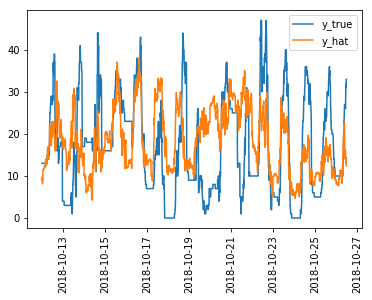

In [82]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()

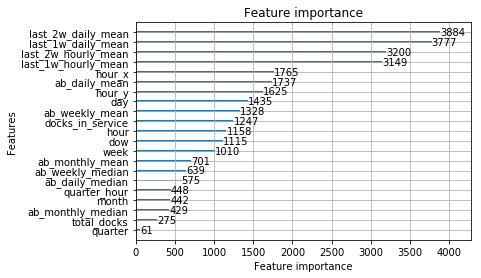

In [84]:
lgb.plot_importance(result.best_estimator_)

In [110]:
def filter_by_sation_id(df, station_id):
    # filter data by station_id
    df = df[df.id == station_id]
    df['ts'] = pd.to_datetime(df.ts, infer_datetime_format=True)
    return df

def round_ts(df):
    # round ts every 5 minutes (seconds are not aligned)
    df.loc[:, 'ts'] = df.ts.dt.round('5min')
    df.sort_values(by='ts', inplace=True)
    return df

def resample_data(df):
    return df.set_index('ts').resample('10Min', how='last', base=5).bfill()

def compute_features(df):
    # every hour we have 6 rows, one every 10 minutes
    entries_per_hour = 6
    # month of year
    df['month'] = df.index.month
    # quarter of year
    df['quarter'] = df.index.quarter
    # day of month
    df['day'] = df.index.day
    # hour of day
    df['hour'] = df.index.hour
    # cyclic features for hour
    df['hour_x'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_y'] = np.cos(2*np.pi*df['hour']/24)
    # quarter of hour
    df['quarter_hour'] = np.floor(df.index.minute / 15)
    # day of week
    df['dow'] = df.index.dayofweek
    # week of year
    df['week'] = df.index.weekofyear
    
    ab_daily_mean = df.groupby('day')['available_bikes'].mean()
    ab_monthly_mean = df.groupby('month')['available_bikes'].mean()
    ab_weekly_mean = df.groupby('week')['available_bikes'].mean()

    ab_daily_median = df.groupby('day')['available_bikes'].median()
    ab_monthly_median = df.groupby('month')['available_bikes'].median()
    ab_weekly_median = df.groupby('week')['available_bikes'].median()
    
    for i, x in zip(ab_daily_mean.index, ab_daily_mean):
        df.loc[df.day == i, 'ab_daily_mean'] = x
    
    for i, x in zip(ab_monthly_mean.index, ab_monthly_mean):
        df.loc[df.month == i, 'ab_monthly_mean'] = x

    for i, x in zip(ab_weekly_mean.index, ab_weekly_mean):
        df.loc[df.week == i, 'ab_weekly_mean'] = x

    for i, x in zip(ab_daily_median.index, ab_daily_median):
        df.loc[df.day == i, 'ab_daily_median'] = x

    for i, x in zip(ab_monthly_median.index, ab_monthly_median):
        df.loc[df.month == i, 'ab_monthly_median'] = x

    for i, x in zip(ab_weekly_median.index, ab_weekly_median):
        df.loc[df.week == i, 'ab_weekly_median'] = x
        
    df['last_1w_hourly_mean'] = last_1w_hourly_mean
    df['last_1w_daily_mean'] = last_1w_daily_mean
    df['last_2w_hourly_mean'] = last_2w_hourly_mean
    df['last_2w_daily_mean'] = last_2w_daily_mean
    
    # set status to unknown when status is not available
    df.loc[pd.isna(df.status), 'status'] = 'Unknown'
    
    return df

def train_test_split(df, test_start='20181012'):
    train_df = df.query('20170101 <= ts < {}'.format(test_start))
    test_df = df.query('ts >= {}'.format(test_start))
    
    # overwrite last_1w_hourly_mean, last_1w_daily_mean columns for the second test week 
    # this info is not available at test time!
    idx = test_df.shift(freq=datetime.timedelta(weeks=1))[:entries_per_hour*24*7].index
    features = ['last_1w_hourly_mean', 'last_1w_daily_mean']
    test_df.loc[idx, features] = test_df.loc[idx - datetime.timedelta(weeks=1), features]
    
    # drop first 2 weeks in train, no info for last_1w/2w features
    train_df = train_df.iloc[entries_per_hour*24*7*2:]
    
    print(train_df.shape, test_df.shape)
    print(train_df.index.min(), train_df.index.max(), test_df.index.min(), test_df.index.max())
    
    return train_df, test_df
    
def optimize(train_df, test_df, features, target, iters=50):
    # transform categorical features
    le = LabelEncoder()
    train_df['status'] = le.fit_transform(train_df['status'])
    test_df['status'] = le.transform(test_df['status'])

    bayes_cv_tuner = BayesSearchCV(
        estimator = lgb.LGBMRegressor(
            random_state=42
        ),
        search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'max_depth': (0, 50),
            'max_delta_step': (0, 20),
            'subsample': (0.01, 1.0, 'uniform'),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'bagging_fraction': (0.01, 1.0, 'uniform'),
            'feature_fraction': (0.01, 1.0, 'uniform'),
            'reg_lambda': (1e-9, 1000, 'log-uniform'),
            'reg_alpha': (1e-9, 1.0, 'log-uniform'),
            'min_child_weight': (0, 5),
            'n_estimators': (100, 1000)
        },
        cv = StratifiedKFold(
            n_splits=2,
            shuffle=True,
            random_state=42
        ),
        scoring='neg_mean_squared_error',
        n_jobs = 4,
        n_iter = iters,   
        verbose = 0,
        refit = True,
        random_state = 42
    )
    
    # fit the model
    result = bayes_cv_tuner.fit(train_df[xs_features], train_df[target])
    
    # get predictions
    y_true = test_df[target].values
    y_hat = result.predict(test_df[xs_features].values)
    
    # return score
    return np.sqrt(np.mean((y_true - y_hat)**2)), result

# Iterate over different stations

In [112]:
# some test stations
station_ids = [463, 374,  58, 102,  30,  90, 343, 433, 306,  75]

# lightgbm features to keep
features = ['total_docks', 'docks_in_service', 'status', 'ab_daily_mean', 'ab_monthly_mean', 'ab_weekly_mean',
           'ab_daily_median', 'ab_monthly_median', 'ab_weekly_median', 'hour_x', 'hour_y',
          'month', 'quarter', 'day', 'hour', 'quarter_hour', 'dow', 'week', 'last_1w_hourly_mean',
          'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean']
# target var
target = ['available_bikes']

# keep track of best score
rmses = []
models = []
tests = []

for station_id in station_ids:
    df = filter_by_sation_id(docks_df, station_id)
    df = round_ts(df)
    df = resample_data(df)
    df = compute_features(df)
    train, test = train_test_split(df)
    rmse, model = optimize(train, test, features, target, iters=10)
    rmses.append(rmse)
    models.append(model)
    tests.append(test)
    
    print('Station {} RMSE = {}'.format(station_id, rmse))

(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 463 RMSE = 6.128656409771549
(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 374 RMSE = 7.657941529193962
(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 58 RMSE = 6.951824879368943
(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 102 RMSE = 1.7197937671446417
(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 30 RMSE = 4.943238795169043
(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 90 RMSE = 13.914468836940788
(91440, 30) (2088, 30)
2017-01-15 00:05:00 2018-10-11 23:55:00 2018-10-12 00:05:00 2018-10-26 11:55:00
Station 343 RMSE = 6.216005687714228
(91440, 30) (2088, 30

In [118]:
id_to_index = dict([(station_id, i) for i, station_id in enumerate(station_ids)])
index_to_id = dict([(i, station_id) for i, station_id in enumerate(station_ids)])

(array([736980., 736982., 736984., 736986., 736988., 736990., 736992.,
        736994.]), <a list of 8 Text xticklabel objects>)

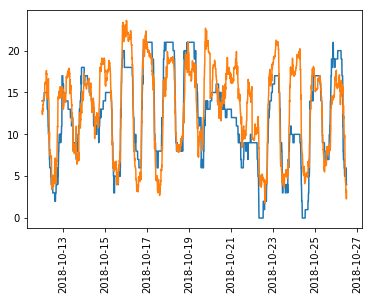

In [126]:
station_id = 374

plt.plot(tests[id_to_index[station_id]].index, 
         tests[id_to_index[station_id]][target], label='y_true')
plt.plot(tests[id_to_index[station_id]].index, 
         models[id_to_index[station_id]].predict(tests[id_to_index[station_id]][xs_features]), label='y_hat')
plt.xticks(rotation=90)